# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
!pip install numpy

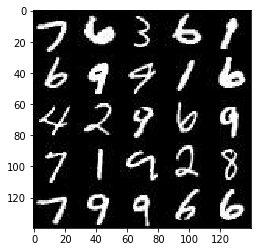

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import pickle as pkl
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

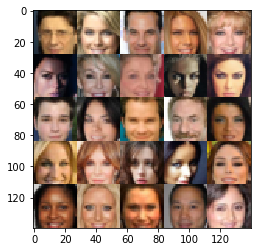

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype=tf.float32, 
                                 shape=(None, image_width, image_height, image_channels),
                                 name='real_images')
    
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim),
                             name='z_input')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    drop_prob = tf.placeholder(dtype=tf.float32, name='drop_prob')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Starts 28x28x3
        x1 = tf.layers.conv2d(images, filters=64,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME',
                             )
        # Now 14x14x64
        a1 = tf.maximum(x1, alpha*x1)
        d1 = tf.layers.dropout(a1,rate=drop_rate)
        
        x2 = tf.layers.conv2d(d1, filters=128,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 7x7x128
        bn1 = tf.layers.batch_normalization(x2, training=True)
        a2 = tf.maximum(bn1, alpha*bn1)
        d2 = tf.layers.dropout(a2, rate=drop_rate)
        
        x3 = tf.layers.conv2d(d2, filters=256,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 4x4x256
        bn2 = tf.layers.batch_normalization(x3, training=True)
        a3 = tf.maximum(bn2, alpha*bn2)
        
        d3 = tf.layers.dropout(a3, rate=drop_rate)
        
        x4 = tf.reshape(d3, shape=(-1, 4*4*256))
        # Now size = [batch_size, 4096 = 4*4*256]
        
        logits = tf.layers.dense(inputs=x4, units=1)
        
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha =0.1
    with tf.variable_scope('generator', reuse= not is_train):
        fc1 = tf.layers.dense(z, units=3*3*512)
        x1 = tf.reshape(fc1, shape=(-1,3,3,512))
        # Shape is 4x4x512
        cn1 = tf.layers.conv2d_transpose(x1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=256,
                                         kernel_size=(5,5),
                                         strides=(1,1),
                                         padding='VALID')
        #print(cn1.shape)
        # Shape should be 7x7x256
        #print(cn1.shape)
        bn1 = tf.layers.batch_normalization(cn1, training=is_train)
        a1 = tf.maximum(bn1, alpha*bn1)
        
        cn2 = tf.layers.conv2d_transpose(a1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=128,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #print(cn2.shape)
        #shape 14x14x128
        #print(cn2.shape)
        bn2 = tf.layers.batch_normalization(cn2, training=is_train)
        a2 = tf.maximum(bn2, bn2*alpha)
        
        cn3 = tf.layers.conv2d_transpose(a2,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=out_channel_dim,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #shape 28x28xout_channel_dim
        #print(cn3.shape)
        output = tf.tanh(cn3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    g_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_fake_outputs, d_fake_logits = discriminator(g_outputs, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits,
        labels=tf.ones_like(d_real_logits)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.zeros_like(d_fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.ones_like(d_fake_logits)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return images_grid

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_images, z_inputs, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    #the numbers for model inputs are determined by the data
    if data_image_mode is "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                z_data = np.random.uniform(low=-1,
                                           high=1,
                                           size=(batch_size, z_dim))
                
                _ =sess.run(d_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                _ =sess.run(g_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                if steps%25==0:
                    train_loss_d = d_loss.eval({z_inputs: z_data, real_images: 2*batch_images})
                    train_loss_g = g_loss.eval({z_inputs: z_data})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100==0:
                    samples.append(show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode))
                    saver.save(sess, './checkpoints/generator.ckpt',global_step=steps)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.7329


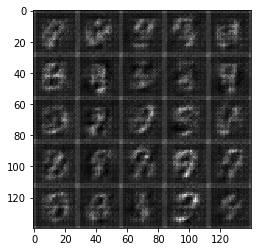

Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 3.4840... Generator Loss: 3.7889
Epoch 1/2... Discriminator Loss: 1.8851... Generator Loss: 0.3971


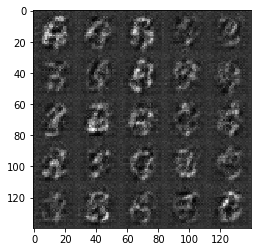

Epoch 1/2... Discriminator Loss: 2.6868... Generator Loss: 2.6515
Epoch 1/2... Discriminator Loss: 3.0303... Generator Loss: 2.7905
Epoch 1/2... Discriminator Loss: 1.8248... Generator Loss: 2.0009
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.7754


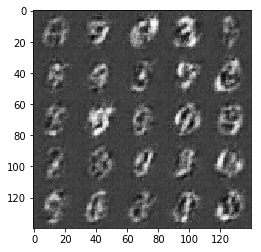

Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 1.8104
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.8359
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 2.3685


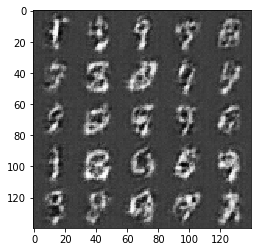

Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 2.5251
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 2.0367
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 2.0910
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 2.0972


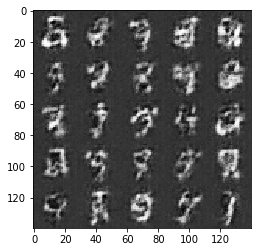

Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 2.1187
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.9821
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 2.0380


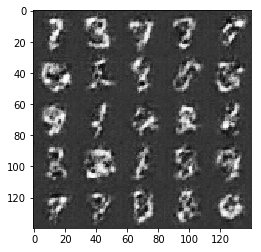

Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 2.7120
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 2.6733
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 2.7198


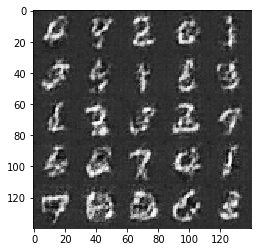

Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.9883
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 3.2355
Epoch 1/2... Discriminator Loss: 1.8056... Generator Loss: 2.3301
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.6015


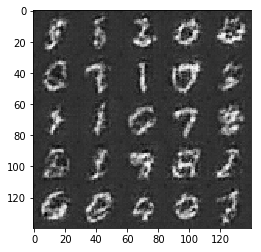

Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.7281
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 3.2867
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 2.6531
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 2.0786


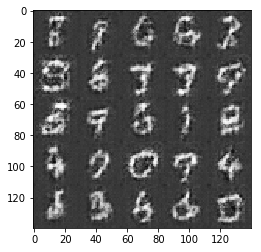

Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 2.8950
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 2.4900
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 2.9186
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 2.3782


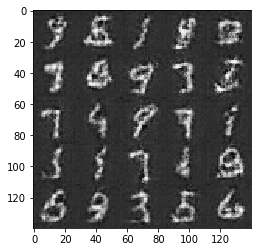

Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 1.7399
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 3.0542
Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 1.7288
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 2.6196


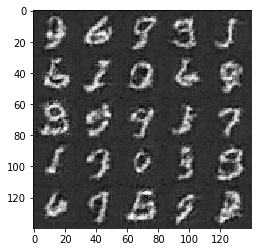

Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 2.5352
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 2.6337


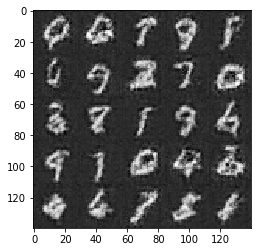

Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 2.2470
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 2.2766
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 2.7022


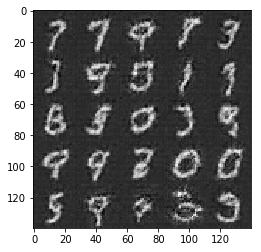

Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 2.5752
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 2.7343
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 2.5547
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 3.1826


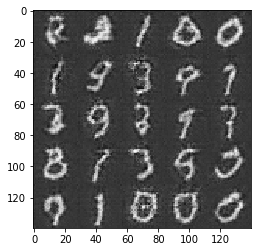

Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 2.0715
Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 1.5867
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.5874


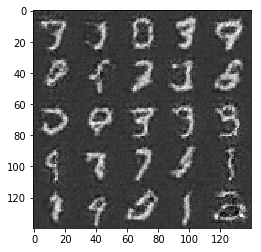

Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 3.2724
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 2.4862
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 3.4770
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 2.3252


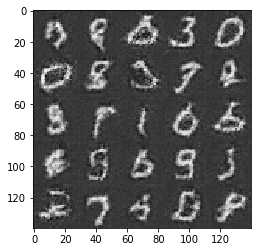

Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 2.3134
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 3.0048
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 4.5612
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 2.3447


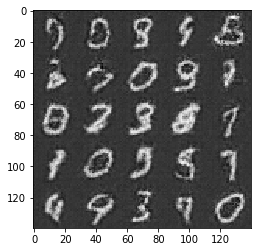

Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.4941
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 2.3767
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.8302


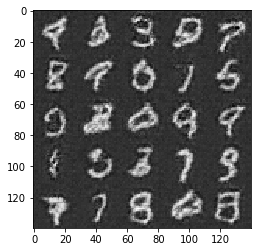

Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 3.4709
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 2.8875
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.2790


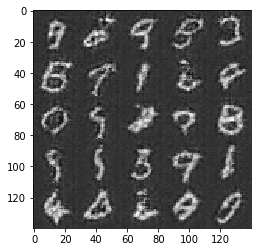

Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 2.8187
Epoch 2/2... Discriminator Loss: 2.1238... Generator Loss: 3.1820
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 2.6645
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 2.4796


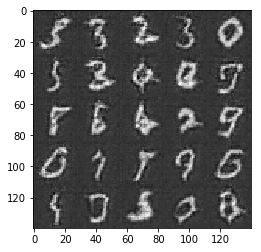

Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.4851
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 4.0303
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 2.3859


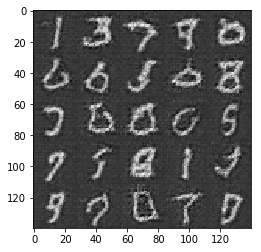

Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 2.0630
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.9728
Epoch 2/2... Discriminator Loss: 4.2977... Generator Loss: 5.2430
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.2075


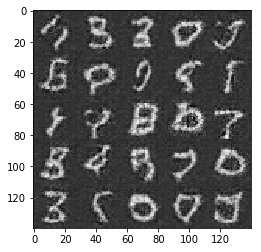

Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.9655
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 3.4154
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 3.1205
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 2.2743


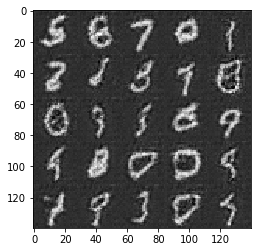

Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 3.1469
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 2.8586
Epoch 2/2... Discriminator Loss: 0.7011... Generator Loss: 2.0359
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 3.3023


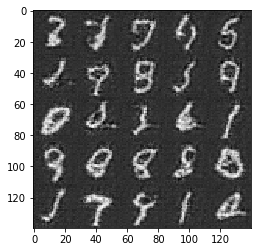

Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 3.1565
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 2.7182
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 2.4429


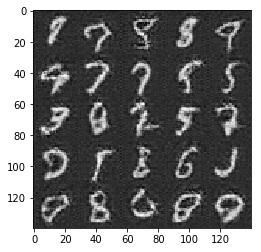

Epoch 2/2... Discriminator Loss: 1.6084... Generator Loss: 3.6363
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 3.9720
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 3.1076
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.8449


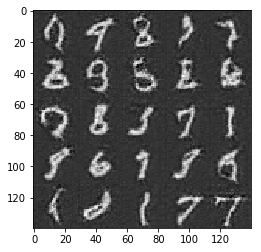

Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 2.7885
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.7586
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 2.1120
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 2.4537


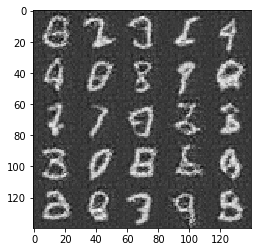

Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 2.0924
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 3.3625
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 2.6528
Epoch 2/2... Discriminator Loss: 1.9263... Generator Loss: 2.7825


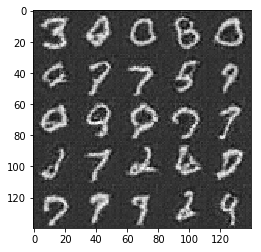

Epoch 2/2... Discriminator Loss: 1.5104... Generator Loss: 3.1262
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.7156
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.1269


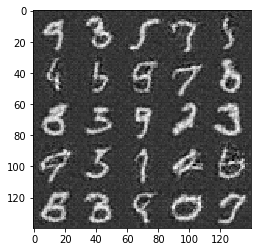

Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 2.2739
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 2.4479
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 3.5147
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 2.9536


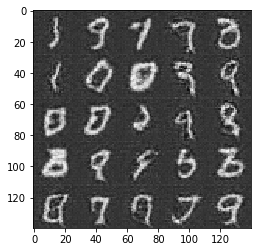

Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 2.5402
Epoch 2/2... Discriminator Loss: 1.6378... Generator Loss: 3.4119
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 2.2014


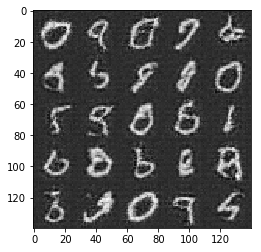

Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 2.2484
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 2.0475
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 2.1098


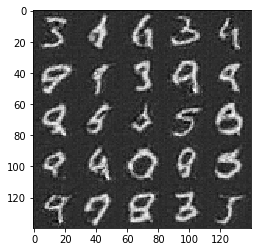

Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 3.1333
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.9795
Epoch 2/2... Discriminator Loss: 2.0817... Generator Loss: 4.0332
Epoch 2/2... Discriminator Loss: 1.8042... Generator Loss: 4.1047


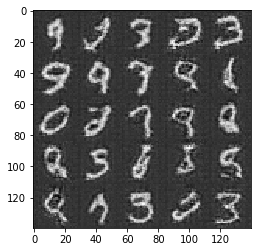

Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 2.9803
Epoch 2/2... Discriminator Loss: 1.7776... Generator Loss: 2.9770
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 3.7771
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 2.4116


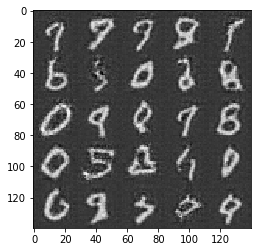

Epoch 2/2... Discriminator Loss: 2.3059... Generator Loss: 2.2544
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 3.5310
Epoch 2/2... Discriminator Loss: 1.7734... Generator Loss: 2.3436
Epoch 2/2... Discriminator Loss: 0.8281... Generator Loss: 2.1415


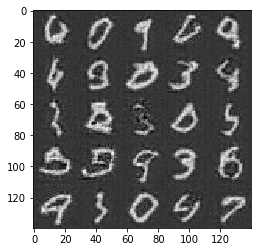

Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 2.2545
Epoch 2/2... Discriminator Loss: 2.4790... Generator Loss: 3.8269
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.2962
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 2.8054


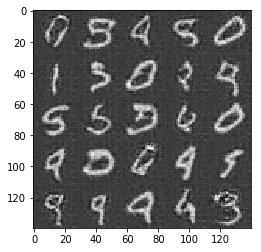

Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 4.0537
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 2.7762
Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 2.1364
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 2.8312


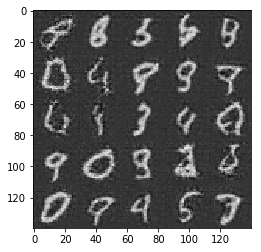

Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 3.7356
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 3.2290


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 2.0595


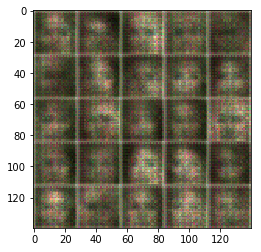

Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 2.2807
Epoch 1/1... Discriminator Loss: 2.7518... Generator Loss: 2.3926
Epoch 1/1... Discriminator Loss: 4.2455... Generator Loss: 2.2681
Epoch 1/1... Discriminator Loss: 3.8192... Generator Loss: 1.5096


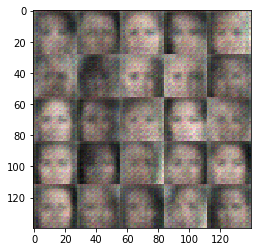

Epoch 1/1... Discriminator Loss: 2.3868... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 4.4074... Generator Loss: 4.6316
Epoch 1/1... Discriminator Loss: 2.3128... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 2.7980... Generator Loss: 5.2967


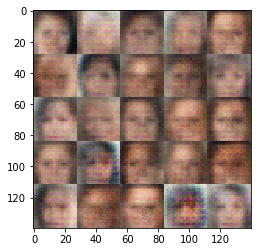

Epoch 1/1... Discriminator Loss: 1.9749... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 2.5600
Epoch 1/1... Discriminator Loss: 1.8905... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 1.8305... Generator Loss: 2.2876


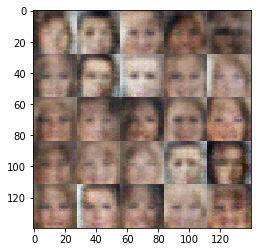

Epoch 1/1... Discriminator Loss: 3.2387... Generator Loss: 3.2724
Epoch 1/1... Discriminator Loss: 2.0899... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 2.3574... Generator Loss: 4.2559
Epoch 1/1... Discriminator Loss: 2.1295... Generator Loss: 1.2853


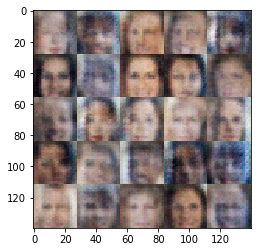

Epoch 1/1... Discriminator Loss: 1.8815... Generator Loss: 1.7296
Epoch 1/1... Discriminator Loss: 2.4952... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 2.7870... Generator Loss: 1.8426
Epoch 1/1... Discriminator Loss: 2.5974... Generator Loss: 3.2836


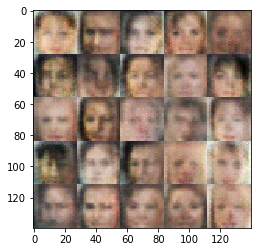

Epoch 1/1... Discriminator Loss: 1.8977... Generator Loss: 5.1435
Epoch 1/1... Discriminator Loss: 2.5577... Generator Loss: 8.1078
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 6.2876
Epoch 1/1... Discriminator Loss: 2.9104... Generator Loss: 7.2449


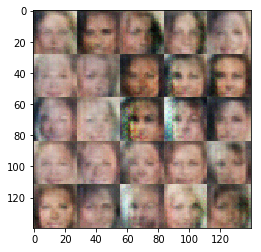

Epoch 1/1... Discriminator Loss: 3.8201... Generator Loss: 9.1243
Epoch 1/1... Discriminator Loss: 1.9396... Generator Loss: 7.8598
Epoch 1/1... Discriminator Loss: 2.1399... Generator Loss: 5.2557
Epoch 1/1... Discriminator Loss: 2.1849... Generator Loss: 2.6581


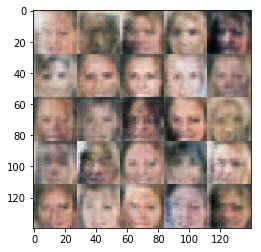

Epoch 1/1... Discriminator Loss: 2.4875... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 2.2944... Generator Loss: 5.1293
Epoch 1/1... Discriminator Loss: 2.3975... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 2.8399... Generator Loss: 1.4222


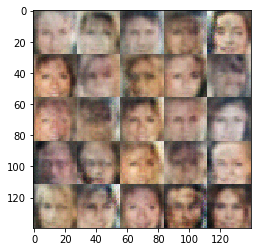

Epoch 1/1... Discriminator Loss: 2.4987... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 3.1000... Generator Loss: 1.9091
Epoch 1/1... Discriminator Loss: 3.3341... Generator Loss: 2.1433
Epoch 1/1... Discriminator Loss: 3.4088... Generator Loss: 6.3286


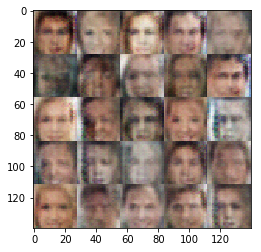

Epoch 1/1... Discriminator Loss: 3.6385... Generator Loss: 3.2040
Epoch 1/1... Discriminator Loss: 3.0105... Generator Loss: 5.9012
Epoch 1/1... Discriminator Loss: 2.8284... Generator Loss: 4.0751
Epoch 1/1... Discriminator Loss: 3.5140... Generator Loss: 8.8031


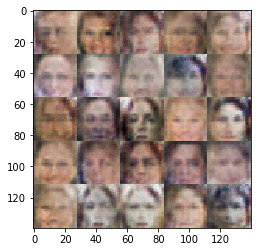

Epoch 1/1... Discriminator Loss: 3.2075... Generator Loss: 6.5458
Epoch 1/1... Discriminator Loss: 3.1343... Generator Loss: 4.1970
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 2.8755
Epoch 1/1... Discriminator Loss: 3.4114... Generator Loss: 8.1949


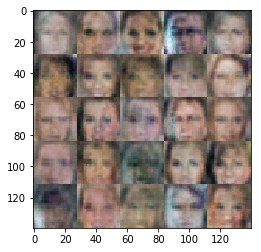

Epoch 1/1... Discriminator Loss: 2.2224... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 3.8494
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 7.8806
Epoch 1/1... Discriminator Loss: 2.2113... Generator Loss: 6.7499


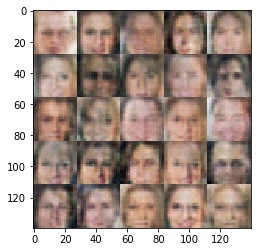

Epoch 1/1... Discriminator Loss: 2.1492... Generator Loss: 4.3120
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 7.4205
Epoch 1/1... Discriminator Loss: 2.2980... Generator Loss: 7.7557
Epoch 1/1... Discriminator Loss: 3.1085... Generator Loss: 6.1534


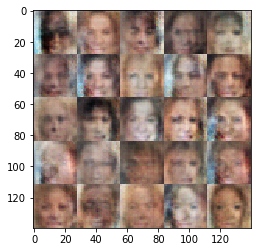

Epoch 1/1... Discriminator Loss: 2.7309... Generator Loss: 7.7070
Epoch 1/1... Discriminator Loss: 2.3892... Generator Loss: 2.0738
Epoch 1/1... Discriminator Loss: 3.1601... Generator Loss: 2.2506
Epoch 1/1... Discriminator Loss: 3.2744... Generator Loss: 8.3241


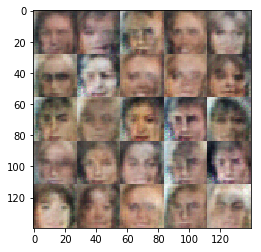

Epoch 1/1... Discriminator Loss: 2.8770... Generator Loss: 3.4852
Epoch 1/1... Discriminator Loss: 2.9872... Generator Loss: 6.7595
Epoch 1/1... Discriminator Loss: 6.7282... Generator Loss: 10.1684
Epoch 1/1... Discriminator Loss: 2.4808... Generator Loss: 2.0393


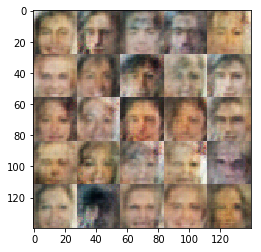

Epoch 1/1... Discriminator Loss: 2.3056... Generator Loss: 9.1080
Epoch 1/1... Discriminator Loss: 3.1053... Generator Loss: 5.3425
Epoch 1/1... Discriminator Loss: 2.6741... Generator Loss: 7.1875
Epoch 1/1... Discriminator Loss: 2.9898... Generator Loss: 3.4872


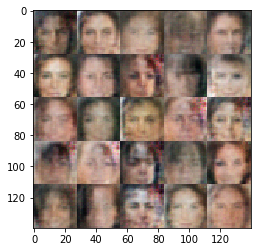

Epoch 1/1... Discriminator Loss: 3.2459... Generator Loss: 5.4558
Epoch 1/1... Discriminator Loss: 2.4426... Generator Loss: 8.1815
Epoch 1/1... Discriminator Loss: 2.8824... Generator Loss: 9.0411
Epoch 1/1... Discriminator Loss: 3.2525... Generator Loss: 8.4133


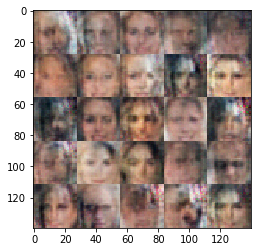

Epoch 1/1... Discriminator Loss: 3.0272... Generator Loss: 5.0798
Epoch 1/1... Discriminator Loss: 2.4744... Generator Loss: 6.8362
Epoch 1/1... Discriminator Loss: 2.0718... Generator Loss: 2.6363
Epoch 1/1... Discriminator Loss: 2.4287... Generator Loss: 3.6978


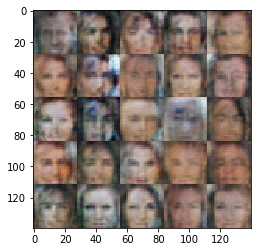

Epoch 1/1... Discriminator Loss: 2.8592... Generator Loss: 9.7541
Epoch 1/1... Discriminator Loss: 2.6920... Generator Loss: 5.9440
Epoch 1/1... Discriminator Loss: 2.7531... Generator Loss: 5.1266
Epoch 1/1... Discriminator Loss: 2.9757... Generator Loss: 9.5689


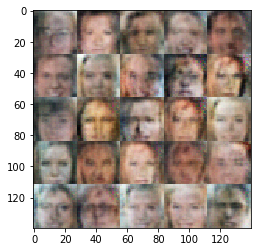

Epoch 1/1... Discriminator Loss: 2.7660... Generator Loss: 7.7315
Epoch 1/1... Discriminator Loss: 3.1075... Generator Loss: 2.5824
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 2.4447... Generator Loss: 9.8267


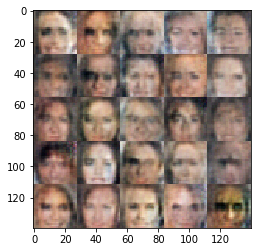

Epoch 1/1... Discriminator Loss: 3.0872... Generator Loss: 5.1230
Epoch 1/1... Discriminator Loss: 2.7708... Generator Loss: 3.4042
Epoch 1/1... Discriminator Loss: 4.8113... Generator Loss: 8.3173
Epoch 1/1... Discriminator Loss: 2.7464... Generator Loss: 5.8022


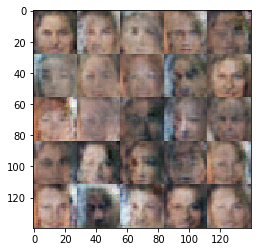

Epoch 1/1... Discriminator Loss: 3.5319... Generator Loss: 3.1643
Epoch 1/1... Discriminator Loss: 2.9405... Generator Loss: 3.4137
Epoch 1/1... Discriminator Loss: 2.8471... Generator Loss: 5.1601
Epoch 1/1... Discriminator Loss: 4.3645... Generator Loss: 11.3873


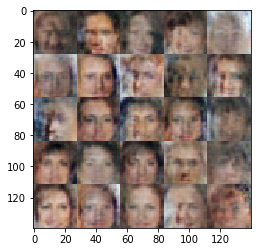

Epoch 1/1... Discriminator Loss: 3.6176... Generator Loss: 9.5260
Epoch 1/1... Discriminator Loss: 2.6215... Generator Loss: 8.1917
Epoch 1/1... Discriminator Loss: 3.4472... Generator Loss: 10.9934
Epoch 1/1... Discriminator Loss: 2.1178... Generator Loss: 6.1753


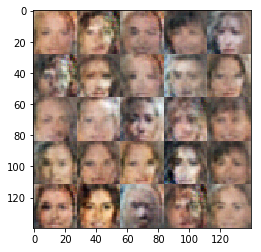

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 3.9721
Epoch 1/1... Discriminator Loss: 2.1686... Generator Loss: 4.1452
Epoch 1/1... Discriminator Loss: 7.0140... Generator Loss: 9.0137
Epoch 1/1... Discriminator Loss: 3.0275... Generator Loss: 4.8056


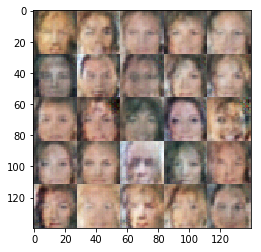

Epoch 1/1... Discriminator Loss: 2.3555... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 4.0241... Generator Loss: 3.0943
Epoch 1/1... Discriminator Loss: 6.5281... Generator Loss: 5.2725
Epoch 1/1... Discriminator Loss: 6.3202... Generator Loss: 6.8029


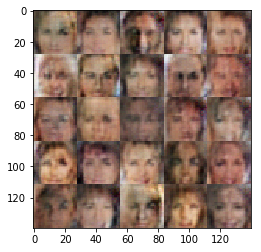

Epoch 1/1... Discriminator Loss: 2.5036... Generator Loss: 5.7656
Epoch 1/1... Discriminator Loss: 2.2843... Generator Loss: 7.5171
Epoch 1/1... Discriminator Loss: 3.3666... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 3.1382... Generator Loss: 2.1392


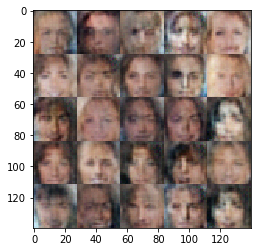

Epoch 1/1... Discriminator Loss: 2.2261... Generator Loss: 5.1635
Epoch 1/1... Discriminator Loss: 3.0722... Generator Loss: 6.5740
Epoch 1/1... Discriminator Loss: 3.0609... Generator Loss: 4.4691
Epoch 1/1... Discriminator Loss: 2.9529... Generator Loss: 5.5002


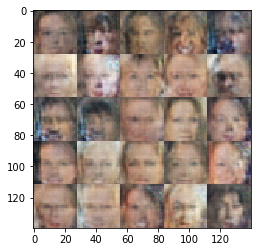

Epoch 1/1... Discriminator Loss: 2.7241... Generator Loss: 7.4391
Epoch 1/1... Discriminator Loss: 1.9278... Generator Loss: 4.4305
Epoch 1/1... Discriminator Loss: 3.0679... Generator Loss: 10.8987
Epoch 1/1... Discriminator Loss: 4.7116... Generator Loss: 11.3069


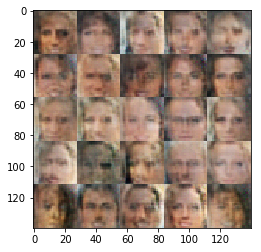

Epoch 1/1... Discriminator Loss: 3.4960... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 2.9867... Generator Loss: 4.1252
Epoch 1/1... Discriminator Loss: 3.9659... Generator Loss: 2.4311
Epoch 1/1... Discriminator Loss: 3.5702... Generator Loss: 4.0278


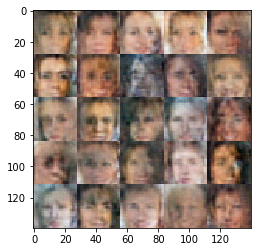

Epoch 1/1... Discriminator Loss: 3.0070... Generator Loss: 5.2729
Epoch 1/1... Discriminator Loss: 3.0217... Generator Loss: 9.8759
Epoch 1/1... Discriminator Loss: 2.3928... Generator Loss: 3.3462
Epoch 1/1... Discriminator Loss: 2.3395... Generator Loss: 3.1163


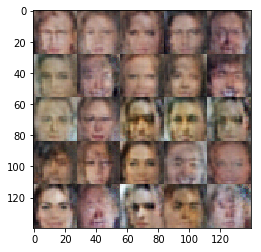

Epoch 1/1... Discriminator Loss: 1.9892... Generator Loss: 4.9433
Epoch 1/1... Discriminator Loss: 3.0933... Generator Loss: 4.3074
Epoch 1/1... Discriminator Loss: 1.9768... Generator Loss: 10.2561
Epoch 1/1... Discriminator Loss: 2.3915... Generator Loss: 4.4576


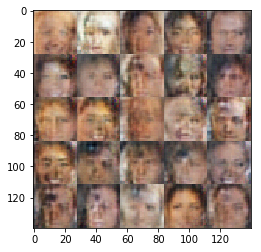

Epoch 1/1... Discriminator Loss: 3.7981... Generator Loss: 5.5858
Epoch 1/1... Discriminator Loss: 2.8483... Generator Loss: 4.2323
Epoch 1/1... Discriminator Loss: 3.1799... Generator Loss: 5.3660
Epoch 1/1... Discriminator Loss: 2.4861... Generator Loss: 2.8189


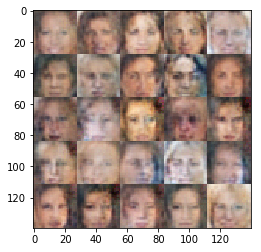

Epoch 1/1... Discriminator Loss: 2.4805... Generator Loss: 4.0375
Epoch 1/1... Discriminator Loss: 3.6283... Generator Loss: 7.7431
Epoch 1/1... Discriminator Loss: 3.5851... Generator Loss: 2.2039
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 7.4305


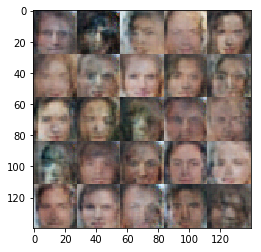

Epoch 1/1... Discriminator Loss: 3.2130... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 4.6418... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 3.5600... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 2.0449


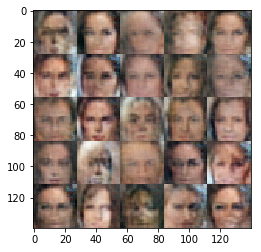

Epoch 1/1... Discriminator Loss: 3.2612... Generator Loss: 7.2825
Epoch 1/1... Discriminator Loss: 2.0709... Generator Loss: 2.8887
Epoch 1/1... Discriminator Loss: 3.0738... Generator Loss: 5.5793
Epoch 1/1... Discriminator Loss: 3.1735... Generator Loss: 4.8561


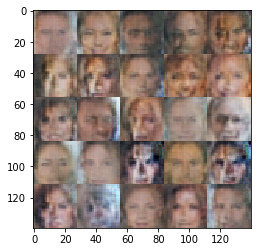

Epoch 1/1... Discriminator Loss: 3.4325... Generator Loss: 4.2061
Epoch 1/1... Discriminator Loss: 3.6360... Generator Loss: 8.1363
Epoch 1/1... Discriminator Loss: 3.0268... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 8.4182


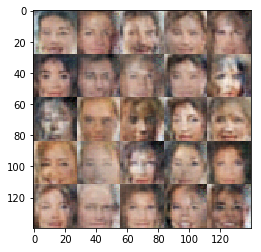

Epoch 1/1... Discriminator Loss: 3.2623... Generator Loss: 4.5277
Epoch 1/1... Discriminator Loss: 3.3194... Generator Loss: 3.4475
Epoch 1/1... Discriminator Loss: 2.8339... Generator Loss: 1.5789
Epoch 1/1... Discriminator Loss: 1.8648... Generator Loss: 9.1224


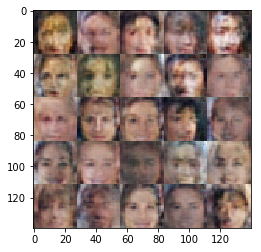

Epoch 1/1... Discriminator Loss: 2.9056... Generator Loss: 3.3500
Epoch 1/1... Discriminator Loss: 2.4700... Generator Loss: 7.6722
Epoch 1/1... Discriminator Loss: 3.0785... Generator Loss: 8.5963
Epoch 1/1... Discriminator Loss: 3.5756... Generator Loss: 0.9939


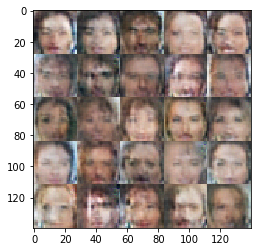

Epoch 1/1... Discriminator Loss: 3.3714... Generator Loss: 7.4724
Epoch 1/1... Discriminator Loss: 4.4758... Generator Loss: 6.1465
Epoch 1/1... Discriminator Loss: 5.4765... Generator Loss: 9.4117
Epoch 1/1... Discriminator Loss: 3.3172... Generator Loss: 6.2325


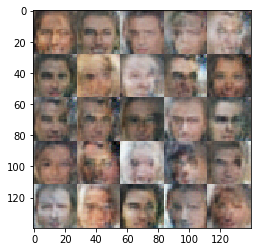

Epoch 1/1... Discriminator Loss: 2.9924... Generator Loss: 4.7516
Epoch 1/1... Discriminator Loss: 4.0616... Generator Loss: 4.4041
Epoch 1/1... Discriminator Loss: 3.1352... Generator Loss: 4.1629
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 2.2476


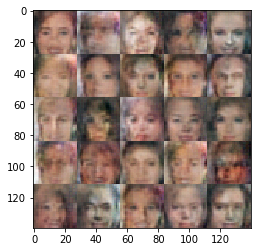

Epoch 1/1... Discriminator Loss: 2.1088... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 2.8140... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 2.9682... Generator Loss: 2.1756
Epoch 1/1... Discriminator Loss: 3.0705... Generator Loss: 1.2542


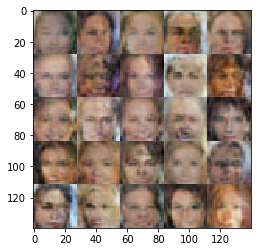

Epoch 1/1... Discriminator Loss: 3.7688... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 3.0290... Generator Loss: 5.0790
Epoch 1/1... Discriminator Loss: 2.6297... Generator Loss: 6.5461
Epoch 1/1... Discriminator Loss: 2.7592... Generator Loss: 6.6399


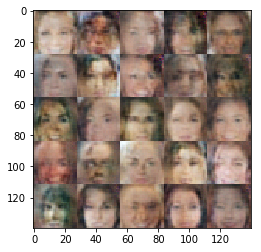

Epoch 1/1... Discriminator Loss: 1.8612... Generator Loss: 9.5397
Epoch 1/1... Discriminator Loss: 4.2163... Generator Loss: 4.1483
Epoch 1/1... Discriminator Loss: 2.3606... Generator Loss: 5.9977
Epoch 1/1... Discriminator Loss: 4.9244... Generator Loss: 9.2839


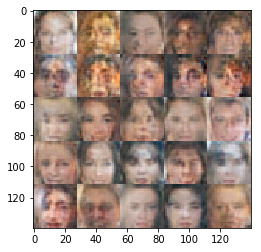

Epoch 1/1... Discriminator Loss: 5.0623... Generator Loss: 4.5735
Epoch 1/1... Discriminator Loss: 5.2822... Generator Loss: 10.0032
Epoch 1/1... Discriminator Loss: 3.5484... Generator Loss: 6.5130
Epoch 1/1... Discriminator Loss: 2.5265... Generator Loss: 9.2142


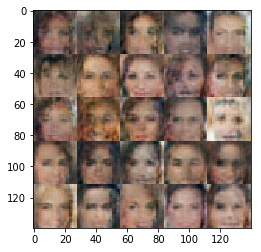

Epoch 1/1... Discriminator Loss: 3.3689... Generator Loss: 2.8985
Epoch 1/1... Discriminator Loss: 1.8250... Generator Loss: 1.9794
Epoch 1/1... Discriminator Loss: 2.5142... Generator Loss: 1.8066
Epoch 1/1... Discriminator Loss: 3.0458... Generator Loss: 3.2863


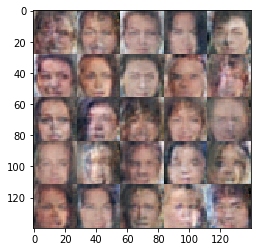

Epoch 1/1... Discriminator Loss: 3.4992... Generator Loss: 4.8106
Epoch 1/1... Discriminator Loss: 2.4456... Generator Loss: 3.8910
Epoch 1/1... Discriminator Loss: 2.5863... Generator Loss: 6.6131
Epoch 1/1... Discriminator Loss: 4.0338... Generator Loss: 4.8233


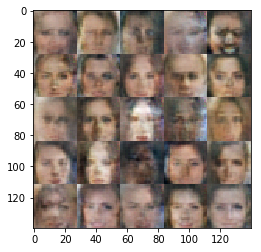

Epoch 1/1... Discriminator Loss: 2.4305... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 2.6226... Generator Loss: 3.8232
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 2.9778
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 2.5434


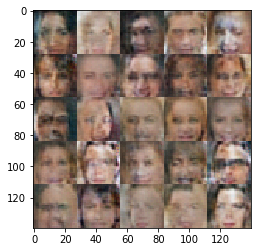

Epoch 1/1... Discriminator Loss: 2.9820... Generator Loss: 6.0355
Epoch 1/1... Discriminator Loss: 4.7487... Generator Loss: 7.9865
Epoch 1/1... Discriminator Loss: 3.7325... Generator Loss: 5.2642
Epoch 1/1... Discriminator Loss: 2.8124... Generator Loss: 3.4204


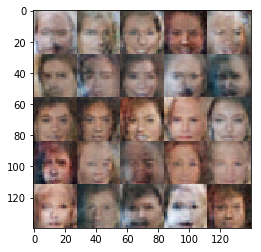

Epoch 1/1... Discriminator Loss: 3.4665... Generator Loss: 7.2614
Epoch 1/1... Discriminator Loss: 2.2181... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 3.9429... Generator Loss: 8.7956
Epoch 1/1... Discriminator Loss: 3.1576... Generator Loss: 6.1330


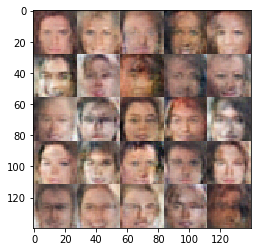

Epoch 1/1... Discriminator Loss: 3.2634... Generator Loss: 2.1623
Epoch 1/1... Discriminator Loss: 2.7387... Generator Loss: 3.4240
Epoch 1/1... Discriminator Loss: 2.5491... Generator Loss: 2.4830
Epoch 1/1... Discriminator Loss: 2.7295... Generator Loss: 7.5471


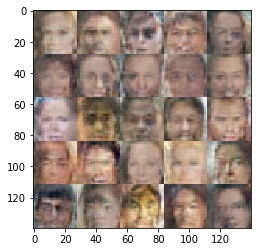

Epoch 1/1... Discriminator Loss: 3.4543... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 3.2058... Generator Loss: 2.6518
Epoch 1/1... Discriminator Loss: 3.5042... Generator Loss: 2.5439
Epoch 1/1... Discriminator Loss: 2.3249... Generator Loss: 2.2892


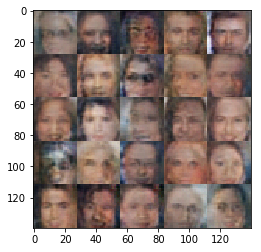

Epoch 1/1... Discriminator Loss: 3.3218... Generator Loss: 8.1066
Epoch 1/1... Discriminator Loss: 2.2637... Generator Loss: 6.0611
Epoch 1/1... Discriminator Loss: 3.8814... Generator Loss: 4.7844
Epoch 1/1... Discriminator Loss: 2.9161... Generator Loss: 3.2930


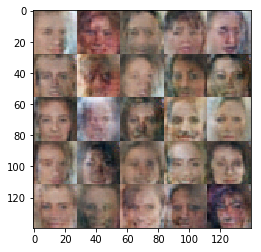

Epoch 1/1... Discriminator Loss: 3.6957... Generator Loss: 4.1607
Epoch 1/1... Discriminator Loss: 4.1990... Generator Loss: 4.2781
Epoch 1/1... Discriminator Loss: 2.9111... Generator Loss: 2.2647
Epoch 1/1... Discriminator Loss: 2.2585... Generator Loss: 1.1574


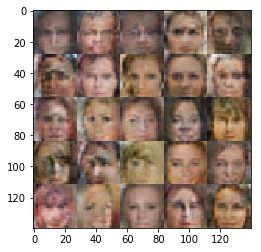

Epoch 1/1... Discriminator Loss: 2.0751... Generator Loss: 3.8220
Epoch 1/1... Discriminator Loss: 2.2670... Generator Loss: 2.4686
Epoch 1/1... Discriminator Loss: 3.0046... Generator Loss: 3.2825
Epoch 1/1... Discriminator Loss: 2.1708... Generator Loss: 1.5828


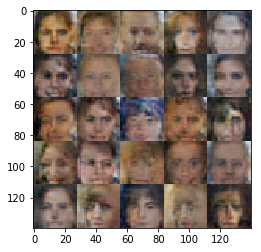

Epoch 1/1... Discriminator Loss: 3.0969... Generator Loss: 4.4775
Epoch 1/1... Discriminator Loss: 3.2510... Generator Loss: 4.6167
Epoch 1/1... Discriminator Loss: 4.0630... Generator Loss: 4.4330
Epoch 1/1... Discriminator Loss: 2.2788... Generator Loss: 1.7194


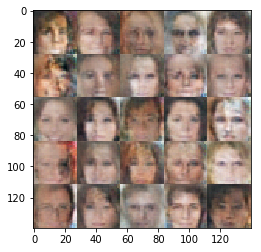

Epoch 1/1... Discriminator Loss: 2.2086... Generator Loss: 3.2690
Epoch 1/1... Discriminator Loss: 5.4405... Generator Loss: 3.6246
Epoch 1/1... Discriminator Loss: 3.0215... Generator Loss: 8.5589
Epoch 1/1... Discriminator Loss: 3.9189... Generator Loss: 5.1485


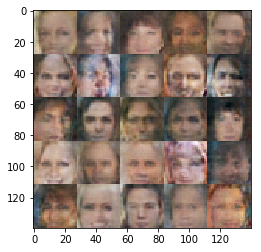

Epoch 1/1... Discriminator Loss: 3.6588... Generator Loss: 6.2256
Epoch 1/1... Discriminator Loss: 3.3170... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 3.7515
Epoch 1/1... Discriminator Loss: 2.8954... Generator Loss: 1.5191


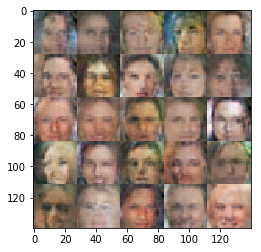

Epoch 1/1... Discriminator Loss: 3.0332... Generator Loss: 5.8816
Epoch 1/1... Discriminator Loss: 2.9215... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 4.4737... Generator Loss: 7.3179
Epoch 1/1... Discriminator Loss: 4.5725... Generator Loss: 12.9208


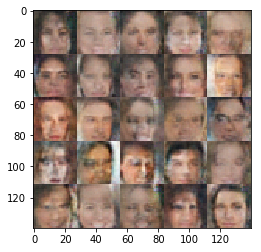

Epoch 1/1... Discriminator Loss: 3.6725... Generator Loss: 11.7582
Epoch 1/1... Discriminator Loss: 2.4536... Generator Loss: 2.8484
Epoch 1/1... Discriminator Loss: 3.0261... Generator Loss: 2.3424
Epoch 1/1... Discriminator Loss: 3.6075... Generator Loss: 1.4071


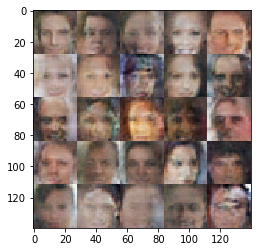

Epoch 1/1... Discriminator Loss: 3.9736... Generator Loss: 1.5573
Epoch 1/1... Discriminator Loss: 5.8813... Generator Loss: 7.4593
Epoch 1/1... Discriminator Loss: 2.7987... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 3.1758... Generator Loss: 7.0431


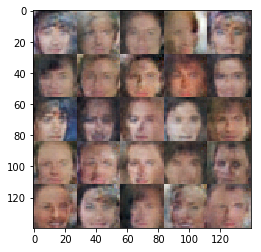

Epoch 1/1... Discriminator Loss: 2.8401... Generator Loss: 4.0546
Epoch 1/1... Discriminator Loss: 3.0020... Generator Loss: 7.0681
Epoch 1/1... Discriminator Loss: 3.9156... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 4.5224... Generator Loss: 1.9313


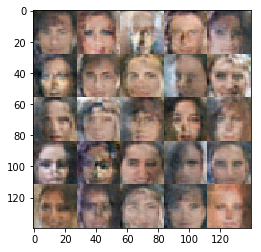

Epoch 1/1... Discriminator Loss: 2.8504... Generator Loss: 3.0061
Epoch 1/1... Discriminator Loss: 2.3150... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 3.1911... Generator Loss: 2.9050


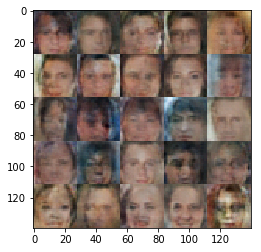

Epoch 1/1... Discriminator Loss: 2.6387... Generator Loss: 2.9794


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.